# PBL 2: Prediction of PTM cross-talk

* Original paper: [Systematic Characterization and Prediction of Post-Translational Modification Cross-Talk](https://www.mcponline.org/article/S1535-9476(20)33238-2/fulltext)
* Data: [PTMX_v1_0.csv.gz](https://github.com/huangyh09/nnwrapper/blob/main/examples/data/PTMX_v1_0.csv.gz)

You may also run it on Google Colab with this link: [PBL2_PTMX_prediction.ipynb](https://colab.research.google.com/github/huangyh09/nnwrapper/blob/main/examples/PBL2_PTMX_prediction.ipynb)

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings # Ignores any warning, to keep the notebook clean
warnings.filterwarnings("ignore")

In [191]:
df = pd.read_csv('PTMX_v1_0.csv')

In [192]:
df

,protein,amino_acid1,PTM1,amino_acid2,PTM2,seq_distance,3D_distance,is_disorded,coevolution,cooccurency,crosstalk_label
0,P31749,T305,O-GlcNAcylation,T308,phosphorylation,3,NaN,0,1.0000,0.6667,1
1,P31749,T312,O-GlcNAcylation,T308,phosphorylation,4,11.3046,0,1.0000,0.6667,1
2,P04083,Y21,phosphorylation,K257,SUMOylation,236,NaN,0,0.0568,0.6667,1
3,P25054,S1505,phosphorylation,S1501,phosphorylation,4,NaN,0,1.0000,0.3333,1
4,P25054,S1501,phosphorylation,S1504,phosphorylation,3,NaN,0,1.0000,0.3333,1
...,...,...,...,...,...,...,...,...,...,...,...
9799,Q9Y6Q9,T1067,PHOSPHORYLATION,K1194,SUMOYLATION,127,NaN,0,0.4060,0.3333,0
9800,Q9Y6Q9,T1067,PHOSPHORYLATION,Y1357,PHOSPHORYLATION,290,NaN,0,0.1645,0.3333,0
9801,Q9Y6Q9,T1114,PHOSPHORYLATION,K1194,SUMOYLATION,80,NaN,0,0.3723,0.3333,0
9802,Q9Y6Q9,T1114,PHOSPHORYLATION,Y1357,PHOSPHORYLATION,243,NaN,0,0.1599,0.3333,0


### Check positive and negative samples

In [193]:
df[df['crosstalk_label'] == 1]

,protein,amino_acid1,PTM1,amino_acid2,PTM2,seq_distance,3D_distance,is_disorded,coevolution,cooccurency,crosstalk_label
0,P31749,T305,O-GlcNAcylation,T308,phosphorylation,3,NaN,0,1.0000,0.6667,1
1,P31749,T312,O-GlcNAcylation,T308,phosphorylation,4,11.3046,0,1.0000,0.6667,1
2,P04083,Y21,phosphorylation,K257,SUMOylation,236,NaN,0,0.0568,0.6667,1
3,P25054,S1505,phosphorylation,S1501,phosphorylation,4,NaN,0,1.0000,0.3333,1
4,P25054,S1501,phosphorylation,S1504,phosphorylation,3,NaN,0,1.0000,0.3333,1
...,...,...,...,...,...,...,...,...,...,...,...
188,P46937,S397,phosphorylation,S403,phosphorylation,6,NaN,1,0.8175,NaN,1
189,P25490,S180,phosphorylation,K178,acetylation,2,NaN,1,0.5961,NaN,1
190,P25490,S180,phosphorylation,K179,acetylation,1,NaN,1,0.6625,NaN,1
191,P25490,S184,phosphorylation,K182,acetylation,2,NaN,1,0.7722,NaN,1


In [194]:
df[df['crosstalk_label'] == 0]

,protein,amino_acid1,PTM1,amino_acid2,PTM2,seq_distance,3D_distance,is_disorded,coevolution,cooccurency,crosstalk_label
193,O14920,S4,PHOSPHORYLATION,S6,PHOSPHORYLATION,2,5.6161,1,0.7272,0.3333,0
194,O14920,S4,PHOSPHORYLATION,T23,PHOSPHORYLATION,19,28.1569,0,0.5100,0.3333,0
195,O14920,S4,PHOSPHORYLATION,K163,UBIQUITINATION,159,40.2699,0,0.0484,0.3333,0
196,O14920,S4,PHOSPHORYLATION,Y169,PHOSPHORYLATION,165,41.2055,0,0.0484,0.3333,0
197,O14920,S4,PHOSPHORYLATION,S177,PHOSPHORYLATION,173,NaN,0,0.0484,0.3333,0
...,...,...,...,...,...,...,...,...,...,...,...
9799,Q9Y6Q9,T1067,PHOSPHORYLATION,K1194,SUMOYLATION,127,NaN,0,0.4060,0.3333,0
9800,Q9Y6Q9,T1067,PHOSPHORYLATION,Y1357,PHOSPHORYLATION,290,NaN,0,0.1645,0.3333,0
9801,Q9Y6Q9,T1114,PHOSPHORYLATION,K1194,SUMOYLATION,80,NaN,0,0.3723,0.3333,0
9802,Q9Y6Q9,T1114,PHOSPHORYLATION,Y1357,PHOSPHORYLATION,243,NaN,0,0.1599,0.3333,0


### Examine some features

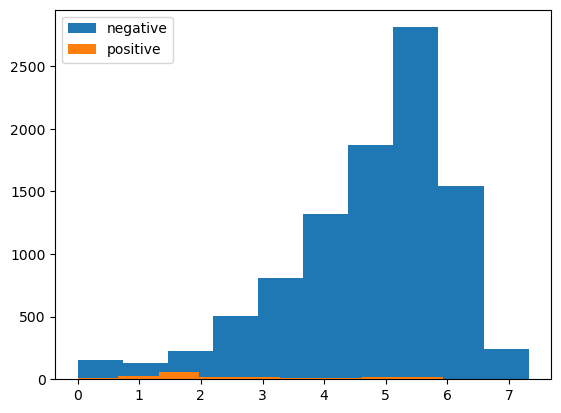

In [195]:
fig = plt.figure()
plt.hist(np.log(df[df['crosstalk_label'] == 0]['seq_distance']), label='negative')
plt.hist(np.log(df[df['crosstalk_label'] == 1]['seq_distance']), label='positive')
plt.legend()
plt.show()

## How to handle missing values?

**Required: describe your strategy in text**

* how did the paper do?
* is it possible for logistic regression? what's your approach?

###### The paper uses Naive Bayes classifier, in which if a PTM pair has a missing value for a feature, that feature is simply omitted from the calculation of the posterior probability for that pair. This allows the model to handle missing data without excluding entire rows that constain some missing values.

###### Yes, using logistic regression is a possible solution. Missing values can be imputed using logistic regression. My personal approach would be to remove the features is more then 75% of the data is missing or remove all the rows with missing values and generate synthetic data.

In [196]:
# Checking how manu unique values are in each non-numeric column
for col in df.columns:
    if df[col].dtype == 'object':
        print(col, df[col].nunique())

protein 77
amino_acid1 767
PTM1 15
amino_acid2 777
PTM2 14


In [197]:
# Label encoding the non-numeric columns
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

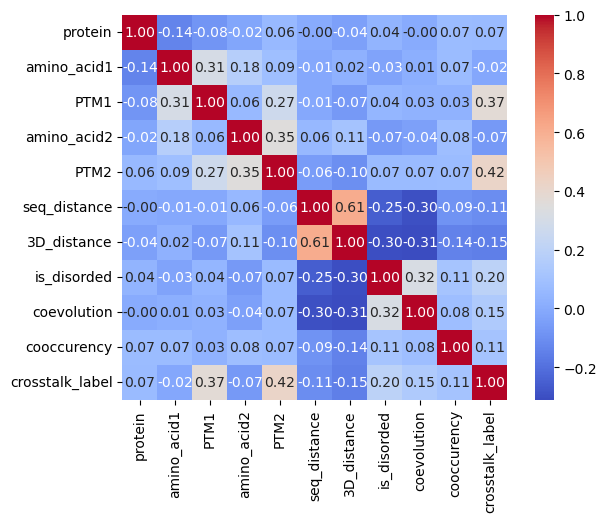

In [198]:
# Plotting a correlation matrix to see how the features are correlated with each other
corr = df.corr()
fig = plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.show()

In [199]:
df.isna().sum() # View the number of missing values in each column

protein               0
amino_acid1           0
PTM1                  0
amino_acid2           0
PTM2                  0
seq_distance          0
3D_distance        7933
is_disorded           0
coevolution         958
cooccurency         136
crosstalk_label       0
dtype: int64

###### We can see roughly 83% of the '3D_distance' column data is missing. Secondaly, there is some multicoliniarity between 'seq_distance' & '3D_distance'. Hence, we will remove the '3D_distance' column from the dataset. As for the coevolution and cooccurency we will use KNNImputer to fill in the missing values (https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/).

In [200]:
# Removing the '3D_distance' column from the dataset.
df = df.drop('3D_distance', axis=1)

# Filling the 'coevolution' and 'cooccurency' columns using KNNImputer
imputer = KNNImputer(n_neighbors=5)
df[['coevolution', 'cooccurency']] = imputer.fit_transform(df[['coevolution', 'cooccurency']])

if df.isna().sum().sum() == 0:
    print('No missing values in the dataset.')
else:
    print('Missing values in the dataset.')

No missing values in the dataset.


## How to handle imbalance between positive and negative samples?

**Required: describe your strategy in text**

* how did the paper do?
* is there any option?

###### In the paper they randomly resampled the control set to match the sample size of the cross-talk set. This was incorporated into their cross-validation methodology, done 10 times. They also did the entire corss validation process 100 times using different control sets and the final result was averaged, this reduced the models potential bias due to sample size imbalance.

###### Another option I would consider is generating synthetic data for the minority class (in this case cross-talk label = 1), although there is risk of introducing bias or overfitting the model. 

In [201]:
# Generating Synthetic data for the minority class (cross-talk = 1) using SMOTE
smote = SMOTE(sampling_strategy='minority') # Only minority class will be oversampled to match the majority class

X = df.drop('crosstalk_label', axis=1)
y = df['crosstalk_label']

X_smote, y_smote = smote.fit_resample(X, y)

print(y_smote.value_counts()) # Counting unique values in 'cross-talk' column

df_smote = pd.DataFrame(X_smote, columns=X.columns) # Creating new dataframe with the synthetic data
df_smote['crosstalk_label'] = y_smote

# Reference documentation of SMOTE function: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

crosstalk_label
1    9611
0    9611
Name: count, dtype: int64


In [202]:
# Function to plot the ROC curve
def plot_roc_curve(fpr, tpr, classifier_name):
    idx = np.min(np.where(tpr > 0.95))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - Sensitivity]')
    plt.ylabel('True Positive Rate')
    plt.title(classifier_name + ' ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [203]:
# Splitting the dataset into training and testing sets
X = df_smote.drop('crosstalk_label', axis=1)
y = df_smote['crosstalk_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # 80% training, 20% testing

In [204]:
# Training the model using Logistic Regression
log_reg = LogisticRegression(random_state = 42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

In [205]:
# Calculating the ROC-AUC score
print('ROC-AUC score:', roc_auc_score(y_test, y_pred))

ROC-AUC score: 0.9851892352062832


## How to assess the model performance?

**Required: Plot an ROC curve**

* How to inteprete ROC curve
* How to specify a threshold, what are the according TPR and FPR?
* How about precision? Is it important here?

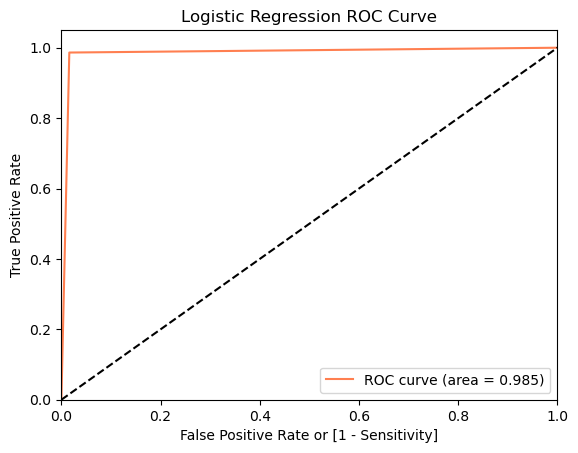

In [206]:
# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr, tpr, 'Logistic Regression')

###### The ROC curve reporesents the perfomance of a binary classification model. It shows the relation/trade-off between the sensitivity (true positive rate) and 1-specifity (false positive rate). Generally speaking, the closer the curve is to the top left corner, the better the perfomance. The Area under the ROC curve represents the overall perfomance. In the model trained above, the ROC curve hugs the top left corner, indicating the classifier is able to distinguish between the positive class and the negative class with high accuracy. This is confirmed by looking at the AUC of 0.985, which indicated a near perfect model. (We need to analyze this futher, as we do not know the effects of the synthetic data).

###### The threshold is a value that allows us to control the trade-off between the true positive rate and false positive rate. Although the specific value of the threshold depends on our specific requirement, we can plot a ROC curve over a range of threshold values and select the best value according to our preference and requirments. Lowering the threshold can increase the TPR but also increases the FPR, and vice versa. (In our case Sklearn logistic regression uses a default threshold value of 0.5)

###### The ROC curve focuses on the trade-off between TPR and FPR, while precision represents the accuracy of the positive predictions made by the model. Both are useful metrics, but when the dataset is significantly unblanced (which is in our case) the ROC curve is a better metric because the majority class dominates the value for accuracy (hence not showing us the true results).

## Is there any issue with common train-test split over the whole dataset? 

**Required: Plot an ROC curve on the test set**
* Comsider TP53 (UniProt ID: P04637) as an example test protein.
* Check how the paper did

###### Yes there is an issue. First, if the dataset is significantly unbalanced it can lead to an inbalanced respresentation of the model perfomance. If the train-test split is randomly done, there is a higher chance of having a disproportionately small number of samples from the minority class in either the test or training set. As a result, the model might not learn well about the minority class, leading to poor performance on unseen data from that class. In our case, it seems like the categorical feature column "protein" has a dominant value of 'P04637', which has  1005 instances when the "crosstalk_label" is 0 and only 23 instances when the "crosstalk_label" is 1. Hence there is a high chance it will be underrepresented in the training set as the model may not learn enough information about 'P04637' protein from in the minority class (crosstalk_label = 1).
 
###### The paper addressed the issue of train-test split by using a specific approach for dividing the data. Training data included cross-talk and control pairs from all proteins except one while the test set consisted of specific cross-talk and control pairs from the selected protein. This essentially ensured the test set's independence from the training set, resulting in a more reliable evaluation of the model's performance.

In [207]:
df = pd.read_csv('PTMX_v1_0.csv') # Reading the original dataset
print(df[(df['crosstalk_label'] == 1) * (df['protein'] == 'P04637')].count())
print("------------------------")
print(df[(df['crosstalk_label'] == 0) * (df['protein'] == 'P04637')].count())

protein            23
amino_acid1        23
PTM1               23
amino_acid2        23
PTM2               23
seq_distance       23
3D_distance        15
is_disorded        23
coevolution        23
cooccurency        23
crosstalk_label    23
dtype: int64
------------------------
protein            1005
amino_acid1        1005
PTM1               1005
amino_acid2        1005
PTM2               1005
seq_distance       1005
3D_distance         176
is_disorded        1005
coevolution        1005
cooccurency        1005
crosstalk_label    1005
dtype: int64
